# Let's get the imports out of the way:

In [14]:
# scikit-learn
from sklearn.metrics.pairwise import cosine_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC

# NLTK
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# NumPy
import numpy as np

# vanilla Python imports
from collections import Counter, OrderedDict
from functools import reduce
import datetime
import zipfile
import glob
import json
import math
import time
import csv
import sys
import io
import os
import re

try:
    import pickle5 as pickle
except ModuleNotFoundError:
    import pickle

# lastly, we handle imports for showing IIIF photos
from IPython.display import Image, display
import requests


# Next, let's load the 1.5 million photos (1900-1963):

In [15]:
# now, we load in the pkl & npy data
with open('datasets/starting_data/global_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)
print("Loaded metadata!")

embeddings = np.load('datasets/starting_data/global_embeddings_light.npy')
print("Loaded embeddings!")

for i in range(0, len(metadata)):
    lowered = metadata[i]['ocr'].lower()
    metadata[i]['lowered_ocr'] = lowered
    metadata[i]['uuid'] = i
print("Lowered all OCR for ease of string matching & added UUIDs!")
    

Loaded metadata!
Loaded embeddings!
Lowered all OCR for ease of string matching & added UUIDs!


# Next, let's define a keyword search and see what results come up:

In [16]:
# given a keyword search, this function returns the results
def keyword_search(search):
    
    res = []
    
    # iterate through each entry
    for i in range(0, len(metadata)):
        
        md = metadata[i]

        # if the search query isn't empty, we find OCR containing query
        if len(search) > 0:

            if 'lowered_ocr' in md.keys():
                # OCR is lowered upon load b/c the lowering operation is quite costly
                if not search in md['lowered_ocr']:
                    continue

        # if the image has made it this far, it's a valid search result
        res.append(md)
        
    # return the results
    return res

# for example, here is a keyword search for "baseball"
results = keyword_search("baseball")
# here, we show the first three results that come back:
for i in range(0, 3):
    # see: https://github.com/LibraryOfCongress/data-exploration/blob/master/IIIF.ipynb
    #display(Image(results[i]['IIIF_downsampled_url']))
    print(results[i])


{'filepath': 'mimtptc_jackson_ver01/data/sn86086633/0029602451A/1910030101/1086/005_0_98.jpg', 'url': 'https://news-navigator.labs.loc.gov/data/mimtptc_jackson_ver01/data/sn86086633/0029602451A/1910030101/1086/005_0_98.jpg', 'page_url': 'https://chroniclingamerica.loc.gov/data/batches/mimtptc_jackson_ver01/data/sn86086633/0029602451A/1910030101/1086.jp2', 'pub_date': '1910-03-01', 'pub_year': 1910, 'pub_month': 3, 'pub_day': 1, 'page_seq_num': 1086, 'edition_seq_num': 1, 'batch': 'mimtptc_jackson_ver01', 'lccn': 'sn86086633', 'name': 'The Calumet news.', 'publisher': 'Mining Gazette Co.', 'place_of_publication': 'Calumet, Mich.', 'score': 0.9830473065376282, 'ocr': "An Important Figure 1 i : ...- -.iW,H 1 r; -- . rry ' fa HUGHEY DOrrfcY NEW NflNACCR- OF THE, WHITEPOX, J in Baseball this", 'box_x1': 0.2947121313062765, 'box_y1': 0.5556275103725282, 'box_x2': 0.038970222202598624, 'box_y2': 0.2514784792636303, 'coverage_county_1': 'Houghton', 'coverage_city_1': 'Calumet', 'coverage_state

# Next, we define a classifier based on a keyword search:

In [17]:
# this function trains the facet learner and predicts on all examples
# positive_indices, negative_indices are used for training
def train_and_predict(positive_indices, negative_indices):

    # set random seed for reproducibility w/ negative examples
    np.random.seed(0)

    # next, we grab the embeddings 
    positive_embeddings = embeddings[positive_indices]
    negative_embeddings = embeddings[negative_indices]

    # construct training data
    train_X = np.concatenate((positive_embeddings, negative_embeddings), axis=0)
    train_y = np.concatenate((np.ones(len(positive_embeddings)), np.zeros(len(negative_embeddings))))
    # set sample weight
    sample_weight = np.ones(len(positive_embeddings) + len(negative_embeddings))
    sample_weight[:len(positive_indices)] = 10
    sample_weight[-len(negative_indices):] = 10

    # create Linear SVM
    # clf = RandomForestClassifier(max_depth=5, random_state=1, n_estimators=100)
    clf = LogisticRegression(class_weight='balanced', random_state=1, max_iter=100000)
    # LinearSVC(class_weight='balanced', verbose=False, max_iter=100000, tol=1e-6, random_state=1)

    # fit to the training data (positive + negative annotations w/ additional, randomly drawn negative examples)
    clf.fit(train_X, train_y, sample_weight)

    # generate predictions
    predictions = clf.predict_proba(embeddings)[:,1]

    return predictions

In [18]:
N_PREDICTIONS = 1000

def train_facet_learner(search):
    
    print("Finding + examples for: " + str(search) + "...")
    
    # let's grab all examples with matching keyword
    results = keyword_search(search)
    
    print("Found " + str(len(results)) + " positive matches")
    
    print("Generating training data...")
    
    # convert to indices
    positive_indices = []
    for result in results:
        positive_indices.append(result['uuid'])
       
#     for i in positive_indices[:10]:
#         display(Image(metadata[i]['IIIF_downsampled_url']))
        
    # generate random negative indices
    n_negative_examples = len(positive_indices)
    random_indices_for_negative = np.arange(len(embeddings))
    np.random.shuffle(random_indices_for_negative)
    random_indices_for_negative = random_indices_for_negative[:n_negative_examples]
    negative_indices = random_indices_for_negative
    
    print("Training and predicting...")

    # train and predict using function defined above
    predictions = train_and_predict(positive_indices, negative_indices)
    
    print("Sorting results & filtering...")
    
    # sort indices of predictions and invert (here, capped @ 1K results)
    sorted_indices = predictions.argsort()[::-1]
    sorted_indices = sorted_indices[:N_PREDICTIONS + len(positive_indices) + len(negative_indices)]
    
    # filter out photos already in library (+ or -)
    filtered_sorted_indices = []
    for index in sorted_indices:
        if index not in positive_indices and index not in negative_indices:
            filtered_sorted_indices.append(index)    
    
    print("Done!")
    return filtered_sorted_indices


In [19]:
facet_learner_results = train_facet_learner('building')

# here, we show the first three results that come back:
for i in facet_learner_results[:20]:
    # see: https://github.com/LibraryOfCongress/data-exploration/blob/master/IIIF.ipynb
    display(Image(metadata[i]['IIIF_downsampled_url']))


Finding + examples for: building...
Found 82 positive matches
Generating training data...
Training and predicting...
Sorting results & filtering...
Done!


IndexError: list index out of range

Finding + examples for: baseball...
Found 5427 positive matches
Generating training data...
Training and predicting...
Sorting results & filtering...
Done!


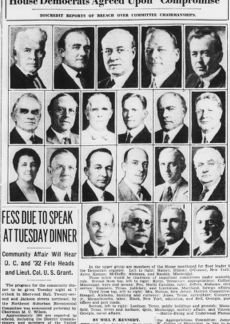

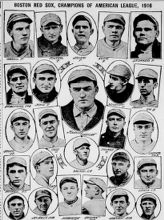

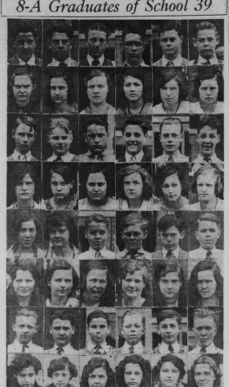

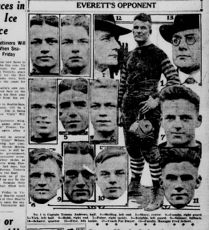

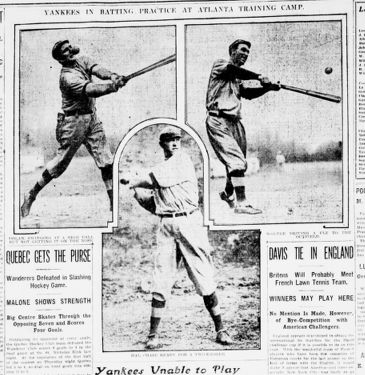

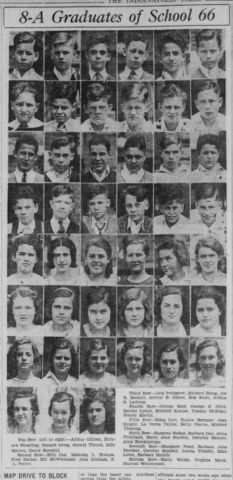

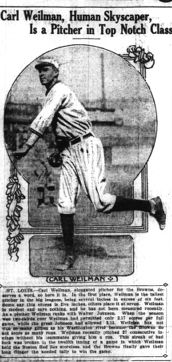

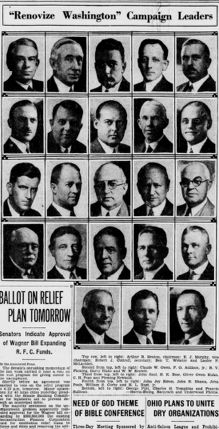

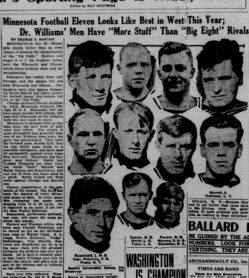

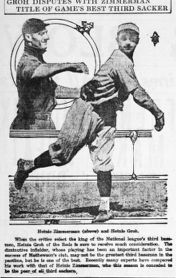

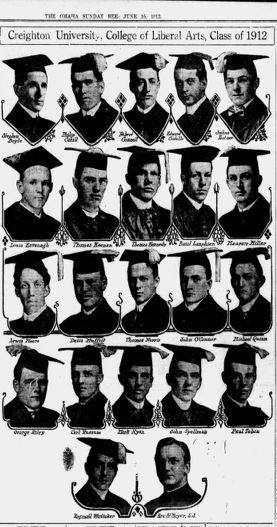

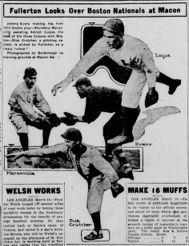

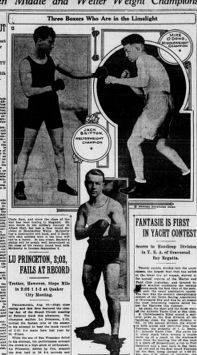

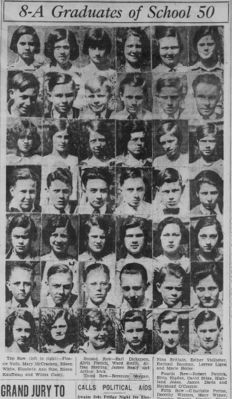

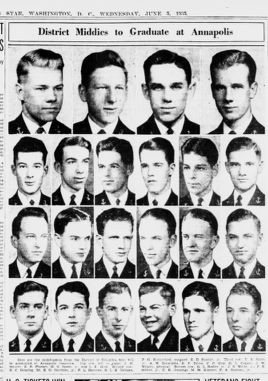

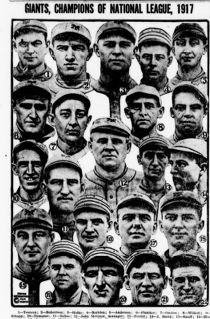

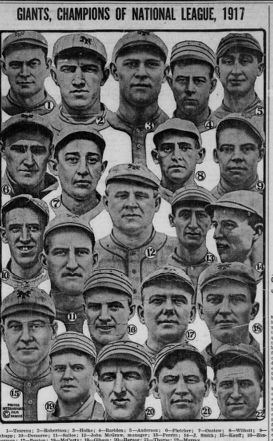

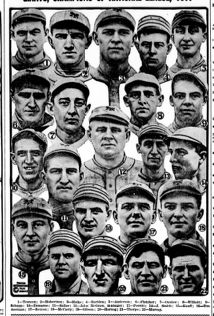

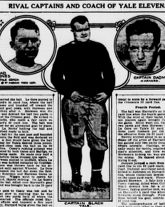

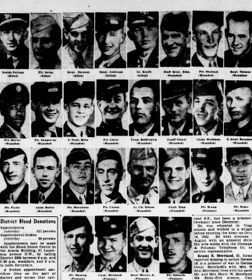

In [ ]:
facet_learner_results = train_facet_learner('baseball')

# here, we show the first three results that come back:
for i in facet_learner_results[:20]:
    # see: https://github.com/LibraryOfCongress/data-exploration/blob/master/IIIF.ipynb
    display(Image(metadata[i]['IIIF_downsampled_url']))


In [ ]:
facet_learner_results = train_facet_learner(' horse ')

# here, we show the first three results that come back:
for i in facet_learner_results[:20]:
    # see: https://github.com/LibraryOfCongress/data-exploration/blob/master/IIIF.ipynb
    display(Image(metadata[i]['IIIF_downsampled_url']))


In [ ]:
facet_learner_results = train_facet_learner(' boxer ')

# here, we show the first three results that come back:
for i in facet_learner_results[:20]:
    # see: https://github.com/LibraryOfCongress/data-exploration/blob/master/IIIF.ipynb
    display(Image(metadata[i]['IIIF_downsampled_url']))